In [1]:
import seaborn as sns; sns.set()
import json
import requests

import pandas as pd
from pandas.io.json import json_normalize
import datetime,time
from datetime import datetime

from math import atan2,degrees
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
import random
from collections import defaultdict

In [4]:
url = "https://api.covid19india.org/states_daily.json"
data = requests.get(url)

content= pd.read_json(data.content)
df=json_normalize(data = content['states_daily'])

In [5]:
cols=df.columns[~df.columns.isin(['status','date'])]

In [6]:
#df['date'] = pd.to_datetime(df.date)

In [7]:
df[cols]= df[cols].apply(pd.to_numeric)

In [8]:
c_df = df.loc[df['status']=='Confirmed'].drop('status',axis=1)

In [9]:
c_df=c_df.reset_index()

In [38]:
g1000=c_df[cols].sum().sort_values(ascending=False)>10000
tops=g1000.index[g1000]

In [11]:
#tops = tops[tops!='un']
#tops = tops[tops!='tt']

In [12]:
dts=df.date

In [13]:
cff=c_df[c_df['date']<=dts.iloc[-1]]
cff=cff[tops].apply(pd.to_numeric, errors='coerce', axis=1)
cff=cff[tops].cumsum()

In [85]:
#this is better than what I came-up with, see commented my code in the chart to understand the logic
def plot_threshold_lines(doubling_lifetime):
    """Add a line for the growth in numbers at a given doubling lifetime."""

    # Find the limits of the line for the current plot region.
    x = np.array([0, MAX_DAYS])
    y = np.log10(MIN_CASES) + x/doubling_lifetime * np.log10(2)
    ymin, ymax = ax.get_ylim()
    if y[1] > ymax:
        y[1] = ymax
        x[1] = doubling_lifetime/np.log10(2) * (y[1] - np.log10(MIN_CASES))
    ax.plot(x, y, ls='--', color='#aaaaaa',alpha=0.6)

    # The reason this matters is that we want to label the linsse at its
    # centre, rotated appropriately.
    s = f'.....Doubling every {doubling_lifetime} days'
    p1 = ax.transData.transform_point((x[0], y[0]))
    p2 = ax.transData.transform_point((x[1], y[1]))
    xylabel = ((x[0]+x[1]+0.1)/2, (y[0]+y[1]+np.log10(1.2))/2)

    dy = (p2[1] - p1[1])
    dx = (p2[0] - p1[0])
    angle = np.degrees(np.arctan2(dy, dx))
    
    rise = (p2[1] - p1[1])
    run = (p2[0] - p1[0])

    slope_degrees = np.degrees(np.arctan2(rise, run))
    if(doubling_lifetime<6):
        slope_degrees += 5.5
    #ax.annotate(s, xy=xylabel, ha='center', va='center', rotation=angle, alpha=0.5)
    ax.annotate(s, xy=xylabel, ha='center', va='center', rotation=slope_degrees, alpha=0.5)


In [15]:
titles = dict(zip(
    ['tt','mh','dl','gj', 'rj',  'mp', 'tn','up', 'tg','ap', 'pb','wb','ka', 'kl', 'jk','br','hr','or','un'],
    ["All India",'Maharashtra', 'Delhi', 'Gujarat', 'Rajasthan','Madhya Pradesh',
         'Tamil Nadu', 'Uttar Pradesh','Telengana','Andhra Pradesh','Punjab', "West Bengal",'Karnataka',
         'Kerala',"Jammu and Kashmir",'Bihar','Haryana','Orisa','*Un Known*']
))

In [16]:
color_map={'br': '#fe0a11', 'gj': '#f0b884', 'ka': '#ddb0ff','dl':'#aafb50','mh':'#10bb5f',
                    'kl':'#a4cc8b', 'mp':'#c48381', 'or':'#f7baeb', 'pb':'#d0bb5f', 'ap':'#d0bb5f',
                    'rj':'#5edef7','tn':'#4287f5', 'tg':'#a0b34f', 'up':'#42fb50','un':'red', 
                    'tt':'#dfcb5f', 'wb':'#b0a1f5','jk':'#afb34f'}

In [17]:
MAX_DAYS=60
MIN_CASES=500

In [18]:
x5 = [a for a in range(0, 50,5)]
y5 = 2**(np.asarray(x5)/5)

In [19]:
x10 = [a for a in range(0, 84,10)]
y10 = 2**(np.asarray(x10)/10)

In [20]:
x2 = [a for a in range(0, 20,2)]
y2 = 2**(np.asarray(x2)/2)

In [21]:
x15 = [a for a in range(0, 90,15)]
y15 = 2**(np.asarray(x15)/15)

In [22]:
ymin = int(np.log10(MIN_CASES))
ymax = int(np.log10(np.nanmax(cff))) + 1

In [23]:
yticks = np.linspace(ymin, ymax, ymax-ymin+1, dtype=int)
yticklabels = [str(10**y) for y in yticks]

In [24]:
today = datetime.today().strftime('%b-%d')

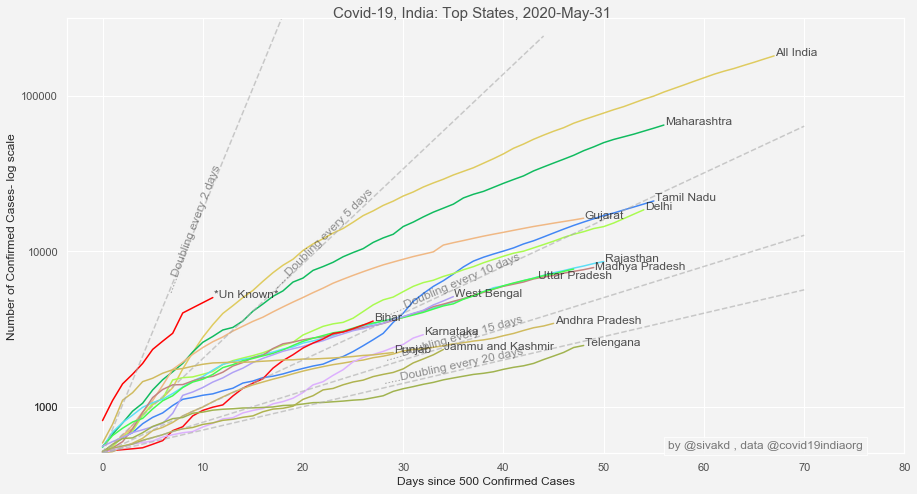

In [87]:
MAX_DAYS=70
MIN_CASES=500
fig, ax = plt.subplots(figsize=(15, 8))
cls = cff.columns
for c in cls:
    cf=cff[cff[c]>MIN_CASES][c].reset_index(drop=True)
    sns.lineplot(ax=ax,x=cf.index, y=np.log10(cf),color=color_map[c])
    if(c=='up'):
        ax.text(cf.index[-1]+0.1, np.log10(cf.iloc[-5]),titles[c], fontsize=12,alpha=0.8,ha='center')
    elif(c=='mp'):
        ax.text(cf.index[-1]+0.1, np.log10(cf.iloc[-2]),titles[c], fontsize=12,alpha=0.8)
    else:
        ax.text(cf.index[-1]+0.1, np.log10(cf.iloc[-1]),titles[c], fontsize=12,alpha=0.8,)
        
#drawing doubling lines logic is generate doubling that is powers of 2 for each incremental doubling days
# and plot using log
#sns.lineplot(ax=ax,x=x5, y=np.log10(MIN_CASES)+np.log10(y5), ls='--', color='#aaaaaa')
#sns.lineplot(ax=ax,x=x10,y=np.log10(MIN_CASES)+np.log10(y10),ls='--', color='#aaaaaa')
#sns.lineplot(ax=ax,x=x2,y=np.log10(MIN_CASES)+np.log10(y2),ls='--', color='#aaaaaa')
#sns.lineplot(ax=ax,x=x15,y=np.log10(MIN_CASES)+np.log10(y15),ls='--', color='#aaaaaa')

plot_threshold_lines(20)
plot_threshold_lines(15)
plot_threshold_lines(10)
plot_threshold_lines(5)
plot_threshold_lines(2)


ymin = int(np.log10(MIN_CASES))
ymax = int(np.log10(np.nanmax(cff))) + 0.5
yticks = np.linspace(ymin+1, ymax, ymax-ymin+1, dtype=int)
yticklabels = [str(10**y) for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,alpha=0.8)
ax.set_ylim(ymin+0.7, ymax)
PLOT_TYPE = 'Confirmed Cases'
ax.set_xlabel('Days since {} {}'.format(MIN_CASES, 'Confirmed Cases'))
ax.set_ylabel(f'Number of {PLOT_TYPE}- log scale')
xticks = range(0,MAX_DAYS+20,10)
xticklabels = [str(x) for x in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,alpha=0.8)
ax.set_facecolor('#f3f3f3')
fig.patch.set_facecolor('#f3f3f3')

fig.suptitle("Covid-19, India: Top States, 2020-"+today,size=15,y=0.90,alpha=0.8)
fig.text(0.95, 0.01, 'by @sivakd , data @covid19indiaorg', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='#f3f3f3', alpha=0.8, edgecolor='white'))

plt.savefig("covid-top-states-double-days"+today+".png",bbox_inches = "tight",facecolor='#f3f3f3')


In [74]:
x15=[x + 50 for x in x15] 

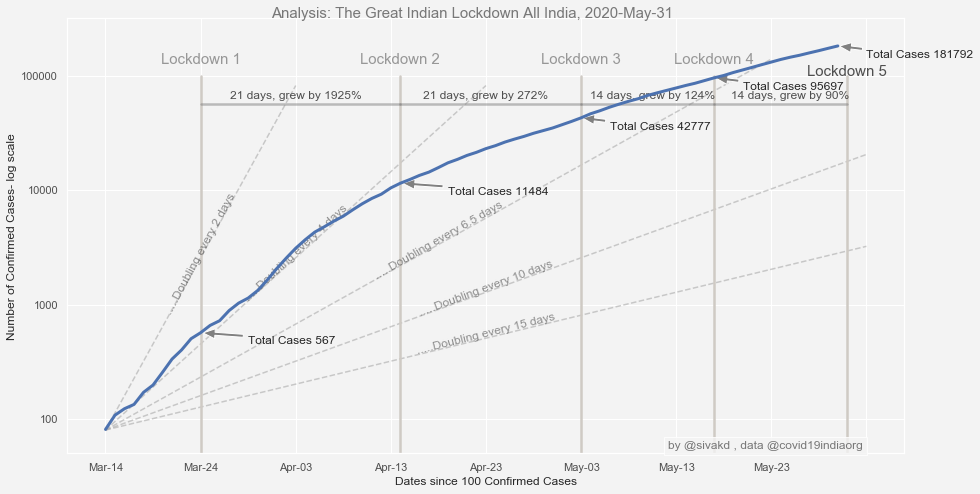

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))

MIN_CASES=80
MAX_DAYS =80
st='tt'
z=0.7
a=0.1
h=4.75
cf=c_df[['date', st]]
sns.lineplot(ax=ax,x=cf.index, y=np.log10(cf[st].cumsum()),
             linewidth=3,zorder=10)#,color=color_map[c])

plot_threshold_lines(15)
MAX_DAYS =80
plot_threshold_lines(10)
MAX_DAYS =70
plot_threshold_lines(6.5)
MAX_DAYS =40
plot_threshold_lines(4)
MAX_DAYS =20
plot_threshold_lines(2)

ly=5
ly1=5.1
a=-0.1
x=10
ax.plot([x, x], [ly, a], linewidth=2.5,color='#cfcac4')
ax.text(x, ly1,"Lockdown 1", fontsize=15,alpha=0.8,ha='center',color='gray')

l1=cases = cf[st].cumsum().loc[10]
y=np.log10(cases)

plt.annotate('Total Cases '+str(cases), xy=(x,y), xytext=(x+5, y-0.1),
             arrowprops=dict(facecolor='gray', shrink=0.05, headwidth=10, width=3))

x=31
ax.plot([x, x], [ly, a], linewidth=2.5,color='#cfcac4')
ax.text(x, ly1,"Lockdown 2", fontsize=15,alpha=0.8,ha='center',color='gray')

l2=cases = cf[st].cumsum().loc[x]
y=np.log10(cases)
plt.annotate('Total Cases '+str(cases), xy=(x,y), xytext=(x+5, y-0.1),
             arrowprops=dict(facecolor='gray', shrink=0.05, headwidth=10, width=3))


ax.plot([50, 50], [ly, a], linewidth=2.5,color='#cfcac4')
ax.text(50, ly1,"Lockdown 3", fontsize=15,alpha=0.8,ha='center',color='gray')

x=50
l3=cases = cf[st].cumsum().loc[x]
y=np.log10(cases)

plt.annotate('Total Cases {}'.format(cases), xy=(x,y), xytext=(x+3, y-0.1),
             arrowprops=dict(facecolor='gray', shrink=0.05, headwidth=10, width=3))

x=64

ax.plot([x, x], [ly, a], linewidth=2.5,color='#cfcac4')
ax.text(x, ly1,"Lockdown 4", fontsize=15,alpha=0.8,ha='center',color='gray')

l4=cases = cf[st].cumsum().loc[x]
y=np.log10(cases)

plt.annotate('Total Cases '+str(cases), xy=(x,y), xytext=(x+3, y-0.1),
             arrowprops=dict(facecolor='gray', shrink=0.05, headwidth=10, width=3))
x=74

ax.plot([x+4, x+4], [ly, a], linewidth=2.5,color='#cfcac4')
ax.text(x+4, ly1-0.1,"Lockdown 5", fontsize=15,alpha=0.8,ha='center')

l5=cases = cf[st].cumsum().loc[77]
y=np.log10(cases)

plt.annotate('Total Cases '+str(cases), xy=(77,y), xytext=(77+3, y-0.1),
             arrowprops=dict(facecolor='gray', shrink=0.05, headwidth=10, width=3))

ax.text(20, h+0.05,"21 days, grew by {:.0f}%".format(((l2-l1)/l1)*100), fontsize=12,alpha=0.8,ha='center')
ax.plot([10, 31], [h,h], linewidth=2.5, alpha=0.5,color='gray')

ax.text(40, h+0.05,"21 days, grew by {:.0f}%".format(((l3-l2)/l2)*100), fontsize=12,alpha=0.8,ha='center')
ax.plot([31, 50], [h, h], linewidth=2.5, alpha=0.5,color='gray')

ax.text(57.5, h+0.05,"14 days, grew by {:.0f}%".format(((l4-l3)/l3)*100), fontsize=12,alpha=0.8,ha='center')
ax.plot([50, 64], [h, h], linewidth=2.5, alpha=0.5,color='gray')

ax.text(72, h+0.05,"14 days, grew by {:.0f}%".format(((l5-l4)/l4)*100), fontsize=12,alpha=0.8,ha='center')
ax.plot([64, 78], [h, h], linewidth=2.5, alpha=0.5,color='gray')


ymin = int(np.log10(MIN_CASES))
ymax = int(np.log10(200000)) + 0.5
yticks = np.linspace(ymin, ymax, ymax-ymin+1, dtype=int)
yticklabels = [str(10**y) for y in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,alpha=0.8)
ax.set_ylim(ymin+z, ymax)
PLOT_TYPE = 'Confirmed Cases'
if(st=='tt'):
    ax.set_xlabel('Dates since {} {}'.format(100, 'Confirmed Cases'))
else:
    ax.set_xlabel('Dates since {} {}'.format(10, 'Confirmed Cases'))

ax.set_ylabel(f'Number of {PLOT_TYPE}- log scale')

xticks= pd.date_range(start='2020-03-04', end='2020-05-25', freq='10D')
xticklabels = [x.strftime('%b-%d') for x in xticks]
#ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,alpha=0.8)
ax.set_facecolor('#f3f3f3')
fig.patch.set_facecolor('#f3f3f3')

st1='All India'

if(st=='tt'):
    fig.suptitle("Analysis: The Great Indian Lockdown {}, 2020-{}".format(str.title(st1),today),size=15,y=0.90,alpha=0.6)
else:
     fig.suptitle("Analysis: The Great Indian Lockdown {}, 2020-{}".format(str.upper(st),today),size=15,y=0.90,alpha=0.6)

fig.text(0.95, 0.01, 'by @sivakd , data @covid19indiaorg', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='#f3f3f3', alpha=0.8, edgecolor='white'))

plt.savefig("The-Great-Indian-Lockdown-Analysis-{}-{}{}".format(st,today,'.png'),bbox_inches = "tight",facecolor='#f3f3f3')

plt.show()

In [27]:
ymin

1